In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *

# Calculating neutrino phase-space distributions.

ic| p_init.shape: (4, 200), p_back.shape: (4, 200)


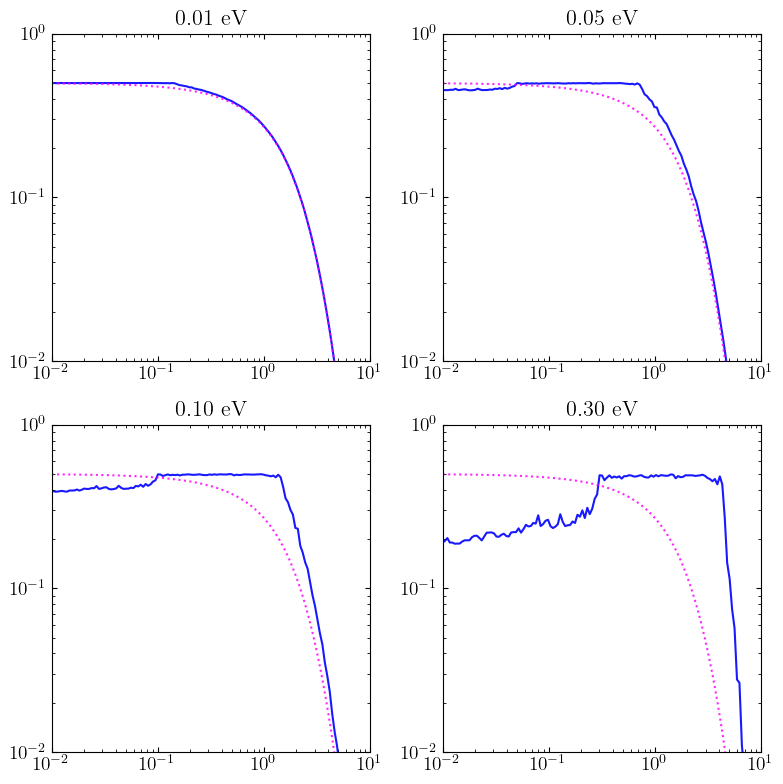

In [2]:
# Load neutrino velocities
file_name = 'neutrino_vectors_numerical_halo13'

nu_vels = jnp.array([
    jnp.load(f'Data/{file_name}_batch{i+1}.npy')[...,3:6]
    for i in range(8)
]).reshape(-1,100,3)

# Convert velocities to momenta
nu_masses = jnp.array([0.01, 0.05, 0.1, 0.3])
p_arr, y_arr = Physics.velocities_to_momenta(nu_vels, nu_masses, Params())

# Select neutrino with highest Fermi-Dirac value of each momentum batch
p_back, y_init = Physics.filter_momenta(p_arr, y_arr, len(nu_masses), Params())
p_init = y_init*Params.T_CNB

ic(p_init.shape, p_back.shape)

# Fermi-Dirac values
f_today = Physics.Fermi_Dirac(p_back, Params())

# Plot phase-space distribution
plt.figure()
for i, m_nu in enumerate(nu_masses):
    plt.subplot(221 + i)

    # Simulation
    plt.plot(y_init[i], f_today[i],
             label='Simulation', c='blue', alpha=0.9)

    # Original Fermi-Dirac
    p_Fermi_Dirac = jnp.geomspace(
        Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
        f_today.shape[-1])
    y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
    f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params())
    plt.plot(y_Fermi_Dirac, f_Fermi_Dirac,
             label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    plt.title(f'{m_nu:.2f} eV')
    plt.ylim(1e-2, 1e0)
    plt.xlim(Params.p_start, 1e1)
    plt.xscale('log')
    plt.yscale('log')

plt.tight_layout()
plt.show()
plt.close()

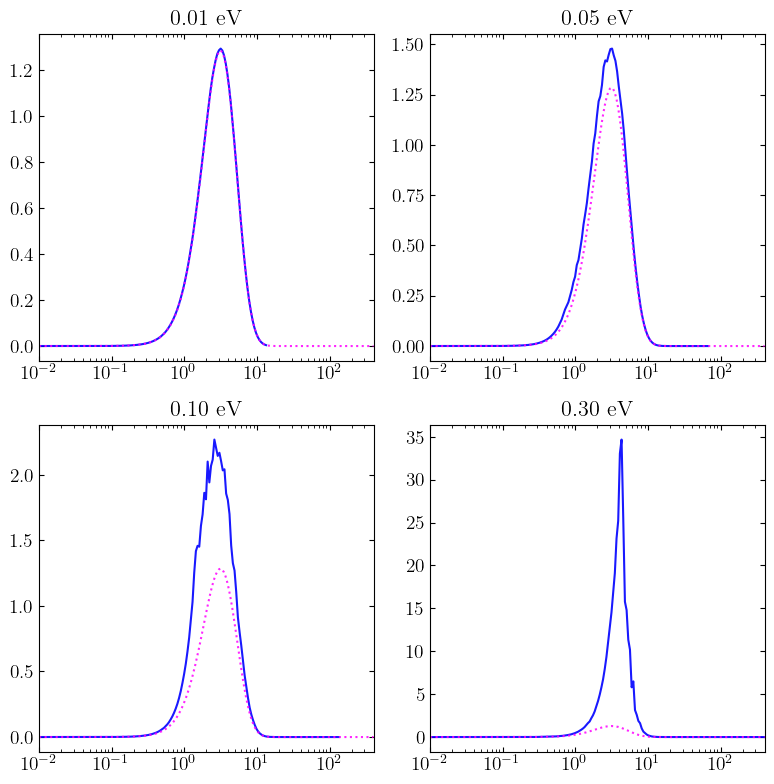

In [3]:
# Plot momentum distribution
plt.figure()
for i, m_nu in enumerate(nu_masses):
    plt.subplot(221 + i)

    # Simulation
    plt.plot(y_init[i], y_init[i]**3*f_today[i],
             label='Simulation', c='blue', alpha=0.9)

    # Original Fermi-Dirac
    p_Fermi_Dirac = jnp.geomspace(
        Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
        f_today.shape[-1])
    y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
    f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params())
    plt.plot(y_Fermi_Dirac, y_Fermi_Dirac**3*f_Fermi_Dirac,
             label='Fermi-Dirac', c='magenta', ls=':', alpha=0.85)

    plt.title(f'{m_nu:.2f} eV')
    plt.xlim(Params.p_start, Params.p_stop)
    plt.xscale('log')

    # plt.ylim(1e-5, 1e2)
    # plt.yscale('log')

plt.tight_layout()
plt.show()
plt.close()

In [5]:
# Choose mass index
m_idx = -1

interpolation_type = 'cubic'

# Interpolate y_init**3*f_today = y_cubed_f
y_cubed_f = y_init[m_idx]**3*f_today[m_idx]
y_cubed_f_interp = interp1d(y_init[m_idx], y_cubed_f, kind=interpolation_type)
y_init_fine = jnp.logspace(
    jnp.log10(y_init[m_idx].min()), jnp.log10(y_init[m_idx].max()), 1000)
y_cubed_f_fine = y_cubed_f_interp(y_init_fine)

# Normalize the distribution to get a PDF
norm = jsp.integrate.trapezoid(y_cubed_f_fine, x=jnp.log10(y_init_fine))
pdf = y_cubed_f_fine / norm

# Compute the CDF
cdf = jnp.cumsum(pdf)
cdf /= cdf[-1]  # Normalize to make it a proper CDF


# The same for Fermi-Dirac distribution
p_Fermi_Dirac = jnp.geomspace(
    Params.p_start*Params.T_CNB, Params.p_stop*Params.T_CNB,
    f_today.shape[-1])
y_Fermi_Dirac = p_Fermi_Dirac/Params.T_CNB
f_Fermi_Dirac = Physics.Fermi_Dirac(p_Fermi_Dirac, Params())

y_cubed_f_Fermi_Dirac = y_Fermi_Dirac**3*f_Fermi_Dirac
y_cubed_f_interp_Fermi_Dirac = interp1d(y_Fermi_Dirac, y_cubed_f_Fermi_Dirac, kind=interpolation_type)
y_init_fine_Fermi_Dirac = jnp.logspace(
    jnp.log10(y_Fermi_Dirac.min()), jnp.log10(y_Fermi_Dirac.max()), 1000)
y_cubed_f_fine_Fermi_Dirac = y_cubed_f_interp_Fermi_Dirac(y_init_fine_Fermi_Dirac)


# Normalize the distribution to get a PDF
norm_Fermi_Dirac = jsp.integrate.trapezoid(y_cubed_f_fine_Fermi_Dirac, x=jnp.log10(y_init_fine_Fermi_Dirac))
pdf_Fermi_Dirac = y_cubed_f_fine_Fermi_Dirac / norm_Fermi_Dirac

# Compute the CDF
cdf_Fermi_Dirac = jnp.cumsum(pdf_Fermi_Dirac)
cdf_Fermi_Dirac /= cdf_Fermi_Dirac[-1]  # Normalize to make it a proper CDF


# Inverse sampling
key = jax.random.PRNGKey(0)
n_samples = 100_000
rand_uniform = jax.random.uniform(key, shape=(n_samples,))  # random numbers in [0,1]

# Find corresponding momentum values using jnp.searchsorted
sampled_indices = jnp.searchsorted(cdf, rand_uniform)
sampled_momenta = y_init_fine[sampled_indices]

sampled_indices_Fermi_Dirac = jnp.searchsorted(cdf_Fermi_Dirac, rand_uniform)
sampled_momenta_Fermi_Dirac = y_init_fine_Fermi_Dirac[sampled_indices_Fermi_Dirac]

# Convert to energies for chosen neutrino mass.
samples_energies = ((sampled_momenta*Params.T_CNB)**2 + nu_masses[m_idx]**2)/Params.meV

samples_energies_Fermi_Dirac = ((sampled_momenta_Fermi_Dirac*Params.T_CNB)**2 + nu_masses[m_idx]**2)/Params.meV


plt.figure()
labels = [r'$p_{sim}$', r'$E_{sim}$', r'$p_{FD}$', r'$E_{FD}$']
colors = ['blue', 'blue', 'orange', 'orange']
titles = [
    r'Neutrino-Momentum distribution, i.e. $\frac{d n_{\nu,0}}{d p_{\nu,0}}$ .',
    r'Neutrino-Energy distribution, i.e. $\frac{d n_{\nu,0}}{d E_{\nu,0}}$ .'
]
xlabels = [
    r'$p_{\nu,0}/T_{\nu,0}$',
    r'$E_{\nu,0}$ [meV]'
]

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

for i, arr in enumerate([
    sampled_momenta, samples_energies,
    sampled_momenta_Fermi_Dirac, samples_energies_Fermi_Dirac]):

    if i in (0,2):
        ax1.hist(arr, bins=100, alpha=0.7, label=labels[i], color=colors[i], density=True)
        ax1.legend(loc='upper right')

        if i == 0:
            ax1.set_title(titles[i])
            ax1.set_xlabel(xlabels[i])
            ax1.set_ylabel(r'# of neutrinos')
    else:
        ax2.hist(arr, bins=100, alpha=0.7, label=labels[i], color=colors[i], density=True)
        ax2.legend(loc='upper right')

        if i == 1:
            ax2.set_title(titles[i])
            ax2.set_xlabel(xlabels[i])
            ax2.set_ylabel(r'# of neutrinos')
            
plt.tight_layout()
plt.show(); plt.close()

RuntimeError: latex was not able to process the following string:
b'# of neutrinos'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmprs8t2vsb e3e45cf1866f924c06a6efc3f82038f4.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./e3e45cf1866f924c06a6efc3f82038f4.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file e3e45cf1866f924c06a6efc3f82038f4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.30 {\rmfamily #
                  of neutrinos}%
No pages of output.
Transcript written on tmprs8t2vsb/e3e45cf1866f924c06a6efc3f82038f4.log.




Error in callback <function _draw_all_if_interactive at 0x7d3bb474c5e0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'# of neutrinos'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp245_3mfs e3e45cf1866f924c06a6efc3f82038f4.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./e3e45cf1866f924c06a6efc3f82038f4.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file e3e45cf1866f924c06a6efc3f82038f4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.30 {\rmfamily #
                  of neutrinos}%
No pages of output.
Transcript written on tmp245_3mfs/e3e45cf1866f924c06a6efc3f82038f4.log.




RuntimeError: latex was not able to process the following string:
b'# of neutrinos'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp5ecr5xio e3e45cf1866f924c06a6efc3f82038f4.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./e3e45cf1866f924c06a6efc3f82038f4.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file e3e45cf1866f924c06a6efc3f82038f4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in vertical mode.
l.30 {\rmfamily #
                  of neutrinos}%
No pages of output.
Transcript written on tmp5ecr5xio/e3e45cf1866f924c06a6efc3f82038f4.log.




<Figure size 800x800 with 2 Axes>

### **Observation:** 
There is a huge difference between 0.1 eV and 0.3 neutrinos. Almost like a threshold, which moves the whole peak of the simulation momenta/energies to the right. Before this, the Fermi-Dirac and simulation arrays mostly overlap, with the peak of the simulation even lagging behind (i.e. more on the left) a bit.

# Calculating PTOLEMY electron spectra.

## Testing Functions.

4.359373472898389e+17 4.3478683200000006e+17
67.60944943274211 67.66


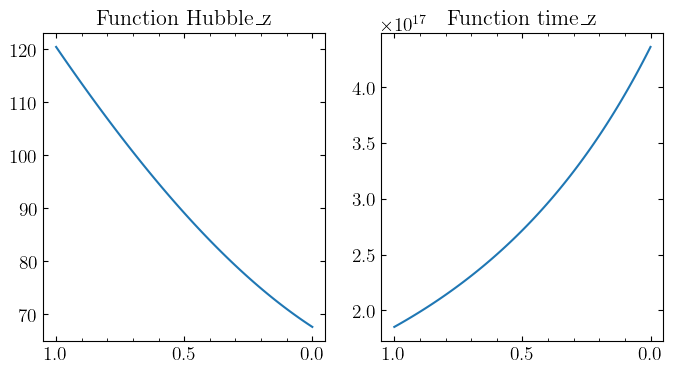

In [6]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

z_range = jnp.linspace(0,1,100)
axs[0].plot(z_range, Physics.Hubble_z(z_range, Params())/(Params.km/Params.s/Params.Mpc))
axs[0].set_title('Function Hubble_z')
axs[1].plot(z_range, Physics.time_z(z_range, Params())/Params.s)
axs[1].set_title('Function time_z')
print(Physics.time_z(z_range, Params())[0]/Params.s, Params.t0/Params.s)
print(Physics.Hubble_z(z_range, Params())[0]/(Params.km/Params.s/Params.Mpc), Params.H0/(Params.km/Params.s/Params.Mpc))

for ax in axs:
    ax.invert_xaxis()

plt.show(); plt.close()

Light neutrino: 50.0 meV. Heavy neutrino: 70.80960386840194 meV
50.0 53.58835232367808


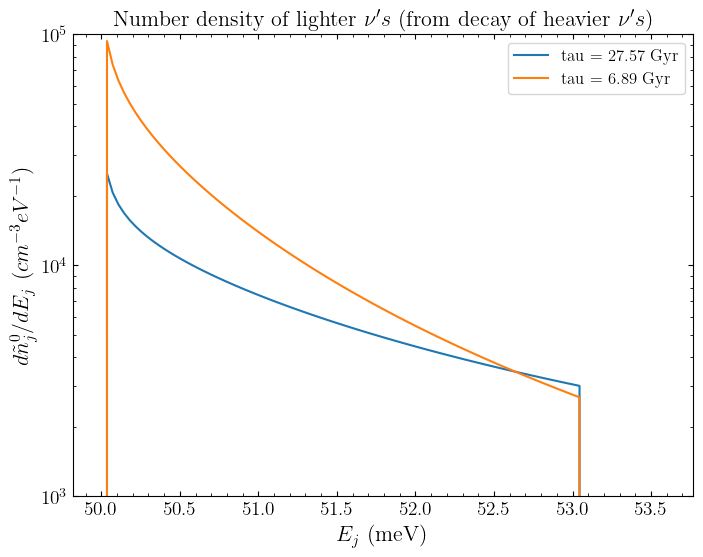

In [7]:
# Neutrino and mediator masses.
m_lightest = 50.*Params.meV
ordering = 'NO'
m_j, _, m_i = Physics.neutrino_masses(m_lightest, ordering, Params())
m_x = 0.*Params.meV
print(f'Light neutrino: {m_j/Params.meV} meV. Heavy neutrino: {m_i/Params.meV} meV')

# Energy Range for nu_1 produced by decays of nu_3 (see text above sect. 5.1.2).
E_j_lower = m_j
E_j_upper = Ptolemy.E_star(m_i, m_j, m_x)*1.01
print(E_j_lower/Params.meV, E_j_upper/Params.meV)
E_range = jnp.linspace(E_j_lower, E_j_upper, 100)
tau_i = 2*Params.t0
n0_i = 56/Params.cm**3

# X_array = jnp.linspace(-40, 80, 100)*meV  # K_e - K0_end (meV)


### Number density, energy spectrum.
fig, ax = plt.subplots(figsize=(8,6))

for tau_i in (2.*Params.t0, Params.t0/2.):
    nj_spec = jnp.array([Ptolemy.dndE_decay(E, m_j, m_i, m_x, tau_i, n0_i, Params()) for E in E_range])
    nj_spec_plot = nj_spec*Params.cm**3*Params.eV
    ax.semilogy(E_range/Params.meV, nj_spec_plot, label=f'tau = {(tau_i/Params.Gyr):.2f} Gyr')

ax.set_title(r"Number density of lighter $\nu's$ (from decay of heavier $\nu's$)")
ax.set_xlabel(r'$E_j$ (meV)')
ax.set_ylabel(r'$d\tilde{n}_j^0 / dE_j$ $(cm^{-3} eV^{-1})$')
ax.set_ylim(1e3, 1e5)

plt.legend()
plt.show(); plt.close()

Max. number density n0_j: 49.27


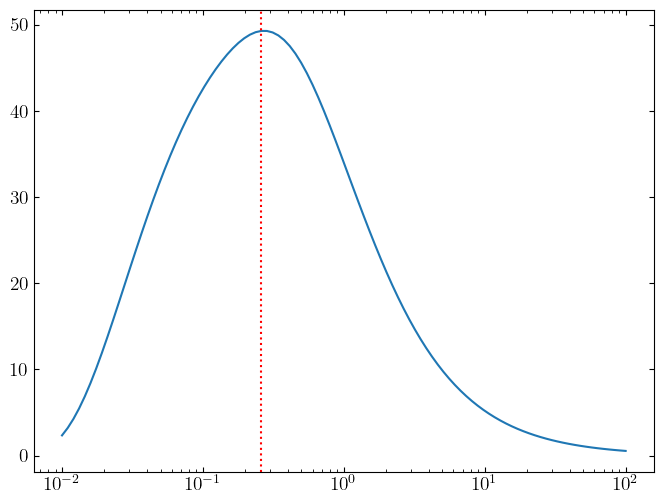

"Optimal" lifetime at 0.26 * t0 
This only happend for large enough E_lower, see comment below.


In [8]:
### Neutrino number densities today, for different decay lifetimes.
lifetimes = jnp.geomspace(1e-1, 1e3, 100)*Params.t0/10
final_n0_j = jnp.zeros(len(lifetimes))
for j, tau_i in enumerate(lifetimes):
    
    n_j_spectrum = jnp.zeros(len(E_range))
    for i, E_j in enumerate(E_range):
        jax_set_1 = Ptolemy.dndE_decay(E_j, m_j, m_i, m_x, tau_i, n0_i, Params())
        n_j_spectrum = n_j_spectrum.at[i].set(jax_set_1)

    jax_set_2 = jsp.integrate.trapezoid(n_j_spectrum, x=E_range)
    final_n0_j = final_n0_j.at[j].set(jax_set_2)


fig, ax = plt.subplots(figsize=(8,6))
lifetimes /= Params.t0
final_n0_j *= Params.cm**3
ax.semilogx(lifetimes, final_n0_j)

max_n0_j = jnp.max(final_n0_j)
print(f'Max. number density n0_j: {max_n0_j:.2f}')
ind = jnp.argwhere(final_n0_j==max_n0_j)
opt_tau = lifetimes[ind]
ax.axvline(opt_tau, ls=':', c='r')
plt.show()
print(
    f'"Optimal" lifetime at {opt_tau[0][0]:.2f} * t0 '
    '\n'
    'This only happend for large enough E_lower, see comment below.'
    )
plt.close()

## Fermi-Dirac spectra.

Total nr. density (should be ~112 for one $m_\nu$): 
 56.69

Ratio of nr. density to LambdaCDM (should be ~1): 
 1.00144

Total nr. densities via energy integration: 
 56.93, 56.94, 56.94, 56.94


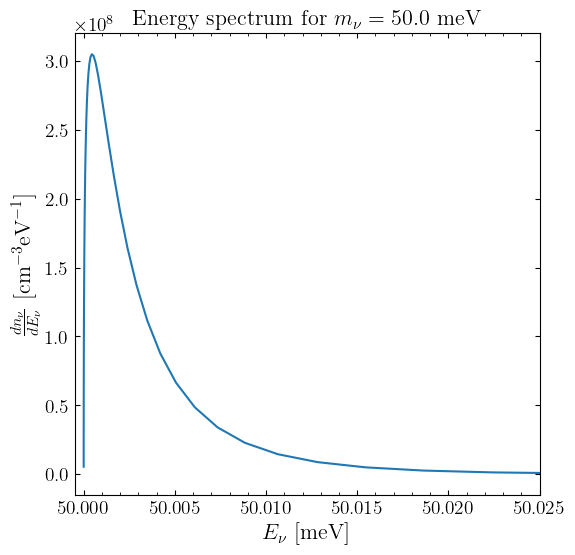

In [9]:
# Neutrino masses
masses_FD = jnp.array([10, 50, 100, 300])*Params.meV

# Momentum sampling (resolution) parameters for Fermi-Dirac spectra
p_start, p_stop, p_num = 0.01*Params.T_CNB, 100*Params.T_CNB, 100

# Energy spectrum for chosen neutrino mass
p_FD, dndp_FD, E_FD, dndE_FD, v_FD = Ptolemy.dndE_Fermi_Dirac(
    masses_FD, p_start, p_stop, p_num, Params())

v_unit = Params.km/Params.s*Params.c

phase_space_factor = Params.g_nu / (2 * Params.Pi**2)

# Check if momentum distribution is normalized correctly
integrand = phase_space_factor * dndp_FD
total_p_nr = jsp.integrate.trapezoid(integrand, p_FD)
print(r'Total nr. density (should be ~112 for one $m_\nu$):', 
      '\n',
      f'{total_p_nr*Params.cm**3:.2f}')
print(
    '\nRatio of nr. density to LambdaCDM (should be ~1):', 
    '\n',
    f'{(total_p_nr/Params.N0):.5f}')

# Equivalently, check if energy distribution is normalized correctly
integrand = phase_space_factor * dndE_FD
total_E_nr = jsp.integrate.trapezoid(integrand, E_FD, axis=-1)
formatted_total_E_nr = [f'{x*Params.cm**3:.2f}' for x in total_E_nr]
print(f'\nTotal nr. densities via energy integration:', 
      '\n',
      ', '.join(formatted_total_E_nr))

# Plot spectrum
plt.figure(figsize=(6,6))
m_idx = 1
plt.title(rf'Energy spectrum for $m_\nu={masses_FD[m_idx]/Params.meV}$ meV')
plt.xlabel(r'$E_\nu$ [meV]')
plt.ylabel(r'$\frac{dn_\nu}{dE_\nu}$ [$\mathrm{cm}^{-3} \mathrm{eV}^{-1}$]')
plt.plot(E_FD[m_idx]/Params.meV, dndE_FD[m_idx]*(Params.eV*Params.cm**3))
plt.xlim(0.99999*masses_FD[m_idx]/Params.meV, masses_FD[m_idx]/Params.meV*1.0005)
plt.show(); plt.close()

In [10]:
# Check if integration (i.e. sum) over the rates/energies gives expected 
# results of ~4/yr and ~8/yr for Dirac and Majorana neutrinos, respectively

def events_per_year(nature, nu_masses, p_start, p_stop, p_num, mode, args):

    # Get momenta, energies and velocities
    p_FD, dndp_FD, E_FD, dndE_FD, _ = Ptolemy.dndE_Fermi_Dirac(nu_masses, p_start, p_stop, p_num, args)

    # Constant factors
    pre = nature * args.U_ei_AbsSq_NO * args.sigma_avg * args.N_T
    phase_space_factor = args.g_nu / (2 * args.Pi**2)

    if mode == 'momentum':
        integral = jsp.integrate.trapezoid(dndp_FD, x=p_FD, axis=-1)
    if mode == 'energy':
        integral = jsp.integrate.trapezoid(dndE_FD, x=E_FD, axis=-1)

    return pre * phase_space_factor * integral


# Neutrino parameters
m_lightest = 50*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params())
nature = 1.
p_start, p_stop, p_num = 0.01*Params.T_CNB, 400*Params.T_CNB, 200

mode = 'momentum'
events_p = events_per_year(nature, nu_masses, p_start, p_stop, p_num, mode, Params())
print(f'Events/year (via momentum) for m_lightest={m_lightest/Params.meV} meV:',
      '\n',
      events_p*Params.yr,
      jnp.sum(events_p*Params.yr),
      '\n')

mode = 'energy'
events_E = events_per_year(nature, nu_masses, p_start, p_stop, p_num, mode, Params())
print(f'Events/year (via energy) for m_lightest={m_lightest/Params.meV} meV:',
      '\n',
      events_E*Params.yr,
      jnp.sum(events_E*Params.yr),
      '\n')

# note: does not seem to matter if integral is linear or log

# note: fixed a bunch of mistakes and confusions related to sigma_avg
# now see if array of velocities work, when using the sigma_avg_19 value
#! careful! need to think about how this assumption is justified or still
#! reflects the underlying physics.

#? maybe it's okay to have the velocity averaged cross section for a proof-of-concept .
#? the momentum information is in the p array anyway, for the FD case and for the
#? grav. modified case

Events/year (via momentum) for m_lightest=50.0 meV: 
 [2.79227056 1.21777438 0.09102556] 4.101070500127086 

Events/year (via energy) for m_lightest=50.0 meV: 
 [2.79622907 1.2195008  0.09115462] 4.1068844962487825 



## X_range and related interpolations

In [11]:
#
# Determine length of x-axis range based on resolution of Fermi-Dirac spectra
#

# Neutrino parameters
m_lightest = 50*Params.meV
ordering = 'NO'
nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params())*Params.eV
nature = 1.

# Momentum sampling (resolution) parameters for Fermi-Dirac spectra
p_start, p_stop, p_num = 0.01*Params.T_CNB, 400*Params.T_CNB, 200

# Energies and spectra for neutrino masses
E_FD, spec_FD = Ptolemy.dGamma_CNB_dE_e_FD(
    nu_masses, ordering, nature, p_start, p_stop, p_num, Params())

# Gaussian Process and convolution (i.e. fft) routine works better with smaller numbers
E_FD /= Params.meV
spec_FD *= (Params.meV*Params.yr)

# Determine energy step needed to resolve smallest peak well enough
# (this is the one for the highest mass)
E_step, *_ = Ptolemy.analyze_peak_for_energy_step(
    E_FD[-1,:], spec_FD[-1,:], points_in_FWHM=10)

# Construct linearly spaced energy ranges for Fermi-Dirac energy ranges
X_linear_FD1 = jnp.arange(E_FD[0,:].min(), E_FD[0,:].max(), E_step)
X_linear_FD2 = jnp.arange(E_FD[1,:].min(), E_FD[1,:].max(), E_step)
X_linear_FD3 = jnp.arange(E_FD[2,:].min(), E_FD[2,:].max(), E_step)

# Interpolate in these energy ranges
Y_linear_FD1, _ = Ptolemy.gpr_interpolation(E_FD[0,:], spec_FD[0,:], X_linear_FD1)
Y_linear_FD2, _ = Ptolemy.gpr_interpolation(E_FD[1,:], spec_FD[1,:], X_linear_FD2)
Y_linear_FD3, _ = Ptolemy.gpr_interpolation(E_FD[2,:], spec_FD[2,:], X_linear_FD3)

# Construct total energy range with same energy step
X_min, X_max = -100, 500
X_range = jnp.arange(X_min, X_max, E_step)

# Pad interpolated array with zeros until it reaches total energy range
zeros_bef_FD1 = int(jnp.abs(X_min - E_FD[0,:].min()) / E_step) + 1
zeros_aft_FD1 = int(jnp.abs(E_FD[0,:].max() - X_max) / E_step)
zeros_bef_FD2 = int(jnp.abs(X_min - E_FD[1,:].min()) / E_step) + 2
zeros_aft_FD2 = int(jnp.abs(E_FD[1,:].max() - X_max) / E_step)
zeros_bef_FD3 = int(jnp.abs(X_min - E_FD[2,:].min()) / E_step) + 1
zeros_aft_FD3 = int(jnp.abs(E_FD[2,:].max() - X_max) / E_step)


# Create padded spectrum
Y_range_FD1 = jnp.concatenate((
    jnp.zeros(zeros_bef_FD1),
    Y_linear_FD1,
    jnp.zeros(zeros_aft_FD1)
))
Y_range_FD2 = jnp.concatenate((
    jnp.zeros(zeros_bef_FD2),
    Y_linear_FD2,
    jnp.zeros(zeros_aft_FD2)
))
Y_range_FD3 = jnp.concatenate((
    jnp.zeros(zeros_bef_FD3),
    Y_linear_FD3,
    jnp.zeros(zeros_aft_FD3)
))
ic(X_range.shape)
ic(Y_range_FD1.shape)
ic(Y_range_FD2.shape)
ic(Y_range_FD3.shape)

# ic(Y_range.shape[0] - X_range.shape[0])  # Check if same sizes

Y_range_total = Y_range_FD1 + Y_range_FD2 + Y_range_FD3

# Create centered Gaussian.
Delta = 10
sigma = Delta/jnp.sqrt(8*jnp.log(2))
mu = (X_min + X_max) / 2.
Gaussian_kernel = Ptolemy.Gaussian_kernel(X_range, mu, sigma, Params())

# Gaussian_kernel = jnp.where(Gaussian_kernel <= 1e-2, 0.0, Gaussian_kernel)



shifted_kernel = jnp.fft.ifftshift(Gaussian_kernel)
plt.plot(X_range, Gaussian_kernel)
plt.plot(X_range, shifted_kernel)
plt.show(); plt.close()

# Check if Gaussian is normalized
area_1 = jsp.integrate.trapezoid(Gaussian_kernel, x=X_range)
ic(area_1)
area_2 = jsp.integrate.trapezoid(shifted_kernel, x=X_range)
ic(area_2)

# ic(Gaussian_kernel.shape[0] - Y_range.shape[0])  # Check if same sizes

/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/fabian/anaconda3/envs/neutrino_clustering/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
i

TypeError: add got incompatible shapes for broadcasting: (3067033,), (3067034,).

In [12]:
# Convolve arrays
convolved_array = Ptolemy.fourier_convolution(Y_range_total, Gaussian_kernel)


NameError: name 'Y_range_total' is not defined

In [ ]:
def plot_convolved_spectrum(x_axis, y_axis):

    plt.figure(figsize=(8, 4))
    plt.semilogy(x_axis, y_axis, 'b-', label='Convolved Spectra')
    plt.title('Spectra Convolution via FFT method')
    plt.legend()
    plt.ylim(1e-2,1e11)
    plt.show()
    # plt.savefig('plot_convolved_spectrum.pdf', bbox_inches='tight')
    plt.close()

plot_convolved_spectrum(X_range, convolved_array)

## PTOLEMY electron spectra plots

Following cell is combining everything previously in notebook into one adjustable function. Previous cells sometimes have errors, which have been addressed in the below master cell (I think).

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


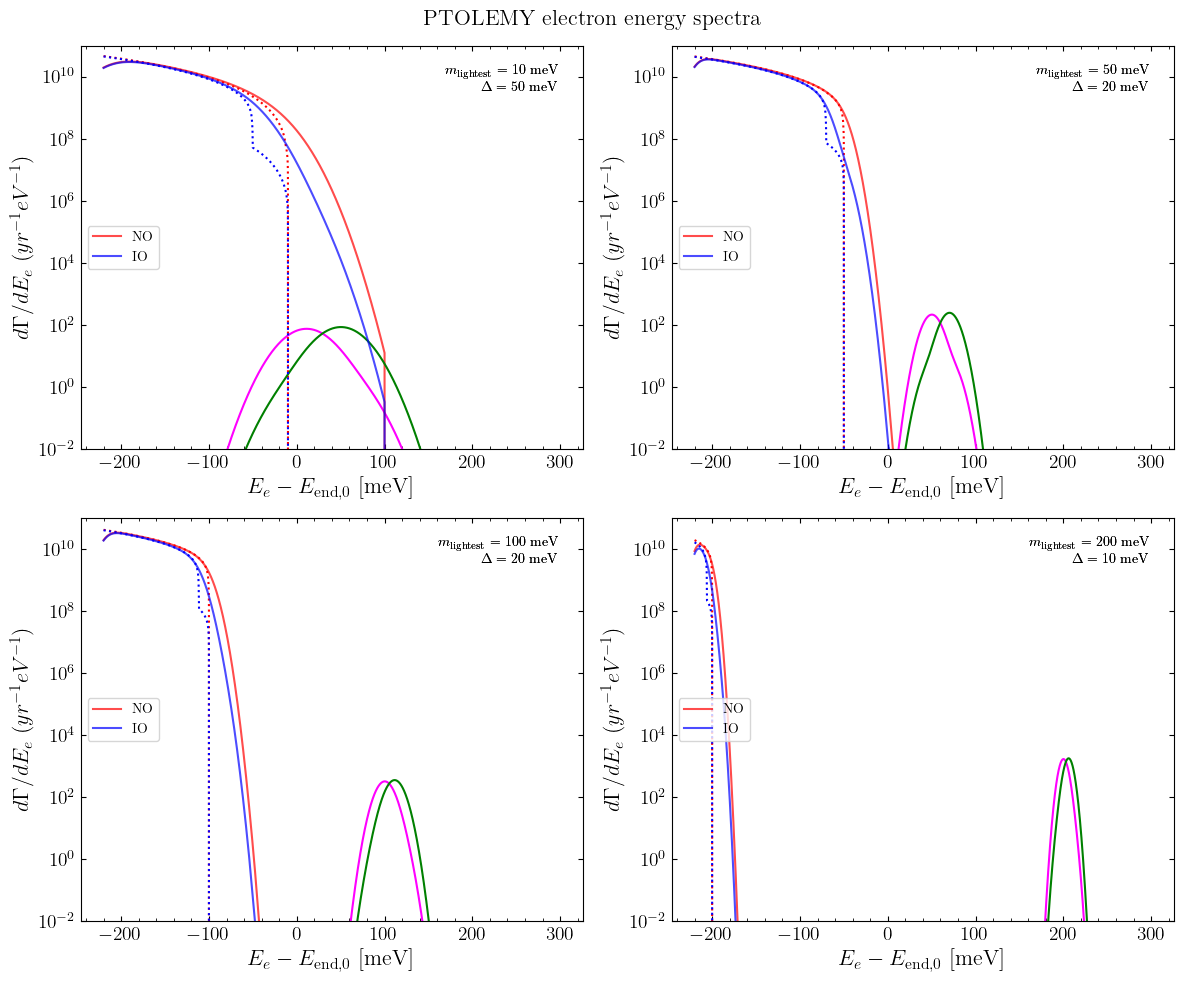

In [3]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning from sklearn.gaussian_process.kernels
warnings.filterwarnings('ignore', category=ConvergenceWarning, module='sklearn.gaussian_process.kernels')


def PLOT_Ptolemy_electron_spectra(spectra_list, m_lightest_arr, Delta_arr):

    # Define the set of valid spectra options
    valid_spectra = [
        "tritium_bkg_true", 
        "tritium_bkg_smeared",
        "fermi_dirac_true",
        "fermi_dirac_smeared",
        "total_true",
        "total_smeared",
        "gaussian_kernel",
        "CNB_sim_smeared"]

    # Helper function to get a string of valid options
    def get_valid_options_str():
        return f"Valid options: {', '.join(valid_spectra)}"

    # Check if spectra_list is empty or contains invalid items
    if not spectra_list:
        raise ValueError("spectra_list is empty. " + get_valid_options_str())
    elif any(spectrum not in valid_spectra for spectrum in spectra_list):
        raise ValueError("Invalid input in spectra_list. " + get_valid_options_str())


    # Lighest neutrino masses to anchor hierarchy
    # m_lightest_arr = [100*Params.meV, 50*Params.meV]  # original

    # PTOLEMY experiment energy resolutions [meV]
    # Delta_arr = [10, 20, 50]  # original

    # Explore both mass orderings
    orders = [
        'NO', 
        'IO'
    ]
    colors = ['red', 'blue']
    sim_colors = ['magenta', 'green']

    # Neutrino nature
    nature = 1.  # 1 = Dirac neutrinos, 2 = Majorana neutrinos

    # Momentum sampling (resolution) parameters for Fermi-Dirac spectra
    p_start = Params.p_start * Params.T_CNB
    p_stop  = Params.p_stop  * Params.T_CNB
    p_num   = Params.p_num

    # Unit for y-axis, i.e. rates per year per energy
    y_unit = Params.yr*Params.eV

    # Plot 4 combinations for the parameters of the PTOLEMY experiment setup
    plt.figure(figsize=(12,10))
    for i in range(4):
        ax = plt.subplot(221 + i)

        # if i != 0:  #! for testing, comment out for full plot
        #     continue

        # if i == 0:  # upper left plot
        #     m_lightest = m_lightest_arr[0]
        #     Delta = Delta_arr[0]
        # elif i == 1:  # upper right plot
        #     m_lightest = m_lightest_arr[1]
        #     Delta = Delta_arr[0]
        # elif i == 2:  # lower left plot
        #     m_lightest = m_lightest_arr[1]
        #     Delta = Delta_arr[1]
        # elif i == 3:  # lower right plot
        #     m_lightest = m_lightest_arr[1]
        #     Delta = Delta_arr[2]

        m_lightest = m_lightest_arr[i]
        Delta = Delta_arr[i]

        # Standard deviation for Gaussian convolution kernel
        sigma = Delta/jnp.sqrt(8*jnp.log(2))

        for ordering, color, sim_color in zip(orders, colors, sim_colors):

            # Get neutrino masses
            nu_masses = Physics.neutrino_masses(m_lightest, ordering, Params())

            # Energies and spectra for neutrino masses
            Es_FD, specs_FD = Ptolemy.dGamma_CNB_dE_e_FD(
                nu_masses, ordering, nature, p_start, p_stop, p_num, Params())
            
            # Work with smaller numbers for numerical stability
            Es_FD /= Params.meV
            specs_FD *= (Params.eV*Params.yr)

            # Determine energy step needed to resolve smallest peak well enough
            # (this is the one for the highest mass)
            E_step, *_ = Ptolemy.analyze_peak_for_energy_step(
                Es_FD[-1,:], specs_FD[-1,:], points_in_FWHM=10)

            # Construct total energy range with same energy step
            # Construct total x-axis (energy) range for spectrum with same energy step
            # (similar to PTOLEMY et al. (2019) Fig. 1, labeled as: E_e - E_{end,0} [meV])
            X_min, X_max = -220, 300
            X_range = jnp.arange(X_min, X_max, E_step)

            # Construct centered Gaussian kernel
            mu = (X_min + X_max) / 2.
            Gaussian_kernel = Ptolemy.Gaussian_kernel(X_range, mu, sigma, Params())
            # Gaussian_kernel = jnp.where(Gaussian_kernel <= 1e-2, 0.0, Gaussian_kernel)

            # Convert to energy range
            E_range = X_range*Params.meV + Params.m_e + Params.K0_end

            if ordering == "NO" and "gaussian_kernel" in spectra_list:
                ax.semilogy(
                    X_range-50, Gaussian_kernel,
                    color='orange', ls='dashdot', alpha=0.5, label=f'Gaussian') 

                # Check if Gaussian is normalized
                # Gaussian_area = jsp.integrate.trapezoid(Gaussian_kernel, x=X_range)
                # ic(Gaussian_area)


            # =============== #
            # Tritium Spectra #
            # =============== #

            # Tritium beta-decay (background) spectrum
            T_beta_spec_true = Ptolemy.Beta_decay_spectrum(
                E_range, nu_masses, ordering, Params())

            # Convolved (i.e. smeared) Trititum beta-decay spectrum
            T_beta_spec_conv = Ptolemy.fourier_convolution(T_beta_spec_true*y_unit, Gaussian_kernel)

            
            # Fourier transform method assumes periodic signal, which beta-spectra are not
            # Therefore, we manually remove artifact on the right side of the plot
            physical_range = (X_range < 100)
            T_beta_spec_conv *= physical_range


            # =================== #
            # Fermi-Dirac Spectra #
            # =================== #

            if "fermi_dirac_true" or "fermi_dirac_smeared" or "total_smeared" in spectra_list:

                spectra_FD_true_l = []
                for m_nu, E_FD, spec_FD in zip(nu_masses, Es_FD, specs_FD):

                    # Gaussian Process and convolution (i.e. fft) routine works better with smaller numbers
                    E_min, E_max = E_FD.min(), E_FD.max()

                    # Construct linearly spaced energy ranges for Fermi-Dirac energy ranges
                    X_linear = jnp.arange(E_min, E_max, E_step)

                    # Interpolate in these energy ranges
                    Y_linear, _ = Ptolemy.gpr_interpolation(E_FD, spec_FD, X_linear)
                    
                    # Pad interpolated array with zeros to match size of total energy range
                    zeros_bef = int(jnp.abs(X_min - E_min) / E_step)
                    zeros_aft = int(jnp.abs(E_max - X_max) / E_step)
                    Y_range = jnp.concatenate((
                        jnp.zeros(zeros_bef),
                        Y_linear,
                        jnp.zeros(zeros_aft)
                    ))

                    # Add additional zero(s) to perfectly match X_range
                    diff = len(X_range) - len(Y_range)
                    if diff != 0:
                        Y_range = jnp.concatenate((Y_range, jnp.zeros(diff)))

                    # Boost by gravitational clustering (analytical method)
                    boost = 1 + Ptolemy.ZhangZhang2018_overdensity(m_nu)
                    Y_range *= boost

                    spectra_FD_true_l.append(Y_range)
                
                # Sum all Fermi-Dirac spectra
                spectra_FD_true = jnp.sum(jnp.array(spectra_FD_true_l), axis=0)

                
                if "fermi_dirac_smeared" or "total_smeared" in spectra_list:

                    # Convolution via FFT method
                    spectra_FD_conv = Ptolemy.fourier_convolution(spectra_FD_true, Gaussian_kernel)
                

                if "fermi_dirac_true" in spectra_list:
                    ax.semilogy(
                        X_range, spectra_FD_true,
                        color=color, ls='solid', alpha=0.7, label=f'{ordering}')
                    

                if "fermi_dirac_smeared" in spectra_list:
                    ax.semilogy(
                        X_range, spectra_FD_conv,
                        color=color, ls='--', alpha=0.7, label=f'{ordering}')



            # ================== #
            # Simulation Spectra #
            # ================== #           

            if "CNB_sim_smeared" in spectra_list:

                Es_sim, specs_sim = Ptolemy.dGamma_CNB_dE_e_simulation(
                    'halo13', nu_masses, ordering, nature, Params())

                Es_sim /= Params.meV
                specs_sim *= (Params.eV*Params.yr)

                spectra_sim_true_l = []
                for E_sim, spec_sim in zip(Es_sim, specs_sim):

                    # Gaussian Process and convolution (i.e. fft) routine works better with smaller numbers
                    E_min, E_max = E_sim.min(), E_sim.max()

                    # Construct linearly spaced energy ranges for CNB sim energy ranges
                    X_linear = jnp.arange(E_min, E_max, E_step)

                    # Interpolate in these energy ranges
                    Y_linear, _ = Ptolemy.gpr_interpolation(E_sim, spec_sim, X_linear)
                    
                    # Pad interpolated array with zeros to match size of total energy range
                    zeros_bef = int(jnp.abs(X_min - E_min) / E_step)
                    zeros_aft = int(jnp.abs(E_max - X_max) / E_step)
                    Y_range = jnp.concatenate((
                        jnp.zeros(zeros_bef),
                        Y_linear,
                        jnp.zeros(zeros_aft)
                    ))

                    # Add additional zero(s) to perfectly match X_range
                    diff = len(X_range) - len(Y_range)
                    if diff != 0:
                        Y_range = jnp.concatenate((Y_range, jnp.zeros(diff)))

                    spectra_sim_true_l.append(Y_range)
                
                # Sum all CNB sim spectra
                spectra_sim_true = jnp.sum(jnp.array(spectra_sim_true_l), axis=0)

                # Convolution via FFT method
                spectra_sim_conv = Ptolemy.fourier_convolution(spectra_sim_true, Gaussian_kernel)
            
                ax.semilogy(
                    X_range, spectra_sim_conv, color=sim_color)
            


            # ========================= #
            # Plot Selection of Spectra #
            # ========================= #

            if "tritium_bkg_true" in spectra_list:
                ax.semilogy(
                    X_range, T_beta_spec_true*y_unit,
                    color=color, ls='dotted')
                
            if "tritium_bkg_smeared" in spectra_list:
                ax.semilogy(
                    X_range, T_beta_spec_conv,
                    color=color, ls='solid', alpha=0.7, label=f'{ordering}')

            if "total_smeared" in spectra_list:
                total_smeared = T_beta_spec_conv + spectra_FD_conv
                ax.semilogy(
                    X_range, total_smeared,
                    color=color, ls='solid', alpha=0.7, label=f'{ordering}')

            ax.text(0.95, 0.95, 
                    rf'$m_\mathrm{{lightest}}={m_lightest/Params.meV:.0f}$ meV'
                    '\n'
                    rf'$\Delta={Delta:.0f}$ meV',
                    fontsize=10, va='top', ha='right', 
                    transform=ax.transAxes)

            ax.legend(loc='center left', prop={'size': 10})
            ax.set_xlabel(r'$E_e - E_{\mathrm{end},0}$ [meV]', fontsize=16)
            ax.set_ylabel(r'$d\Gamma / dE_e$ $(yr^{-1} eV^{-1})$', fontsize=16)
            # ax.set_xlim(-200,300)
            # ax.set_xlim(0.999*m_lightest/Params.meV, 10.25)  # m_lighest = 10 meV
            # ax.set_xlim(50.9,51.25)  # m_lighest = 10 meV, but m_idx = -1
            # ax.set_xlim(0.9999*m_lightest/Params.meV, 100.1)  # m_lighest=100 meV
            ax.set_ylim(1e-2, 1e11)
            
    plt.suptitle('PTOLEMY electron energy spectra')
    plt.tight_layout()
    # plt.savefig('PTOLEMY_electron_spectra_original.pdf', bbox_inches='tight')
    plt.show(); plt.close()


PLOT_Ptolemy_electron_spectra(
    spectra_list=(
        "tritium_bkg_true", 
        "tritium_bkg_smeared",
        # "fermi_dirac_true",
        # "fermi_dirac_smeared",
        # "total_true",
        # "total_smeared",
        # "gaussian_kernel",
        "CNB_sim_smeared",
        ),
    m_lightest_arr=[
        10*Params.meV, 50*Params.meV, 100*Params.meV, 200*Params.meV],
    Delta_arr=[50, 20, 20, 10]
    )